In [5]:
from google.colab import files

uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
# i have to contryct input
# construct output
data = pd.read_csv("dataset.csv").values
x = torch.tensor(data[:, :10], dtype=torch.float32)
y = torch.tensor(data[:, 10:], dtype=torch.float32)
# --- split indices (reproducible) ---
torch.manual_seed(0)
n = x.size(0)
perm = torch.randperm(n)

train_frac, val_frac = 0.70, 0.15
n_train = int(n * train_frac)
n_val   = int(n * val_frac)
n_test  = n - n_train - n_val

train_idx = perm[:n_train]
val_idx   = perm[n_train:n_train + n_val]
test_idx  = perm[n_train + n_val:]

# --- splits ---
x_train, y_train = x[train_idx], y[train_idx]
x_val,   y_val   = x[val_idx],   y[val_idx]
x_test,  y_test  = x[test_idx],  y[test_idx]

print("train:", x_train.shape, y_train.shape)
print("val:  ", x_val.shape,   y_val.shape)
print("test: ", x_test.shape,  y_test.shape)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(10, 20)  # Input layer to hidden layer, we have 10 features
        self.fc2 = nn.Linear(20, 20)  # Hidden layer to output layer4
        self.fc3 = nn.Linear(20, 20)  # Hidden layer to output layer
        self.fc4 = nn.Linear(20, 20)  # Hidden layer to output layer
        self.fc5 = nn.Linear(20, 20)  # Hidden layer to output layer
        self.fc6 = nn.Linear(20, 1)  # Hidden layer to output layer

    def forward(self, x):
        ub = x[:, 3:4]
        lb = x[:, 8:9]
        features = x
        y = torch.sigmoid(self.fc1(features))
        y = torch.sigmoid(self.fc2(y))
        y = torch.sigmoid(self.fc3(y))
        y = torch.sigmoid(self.fc4(y))
        y = torch.sigmoid(self.fc5(y))
        y = torch.sigmoid(self.fc6(y))
        return y * (ub - lb) + lb # it is gonna return a prediction of the longest path starting from a certain node

net = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
epochs = 5000
loss_list = []
for epoch in range(epochs):
    net.train()
    optimizer.zero_grad()        # clear old gradients
    out_tr = net(x_train)              # forward
    loss = criterion(out_tr, y_train)  # compute loss
    loss.backward()              # backprop
    optimizer.step()             # update weights

    if epoch % 100 == 0:
        net.eval()
        with torch.no_grad():
            val_loss = criterion(net(x_val), y_val).item()
        l = loss.item()
        print(f'Epoch [{epoch}/{epochs}], Loss: {l:.6f}')
        loss_list.append(l)
net.eval()
with torch.no_grad():
    test_loss = criterion(net(x_test), y_test).item()
print("test MSE:", test_loss)



train: torch.Size([66165, 10]) torch.Size([66165, 1])
val:   torch.Size([14178, 10]) torch.Size([14178, 1])
test:  torch.Size([14179, 10]) torch.Size([14179, 1])
Epoch [0/5000], Loss: 1.758502
Epoch [100/5000], Loss: 1.398679
Epoch [200/5000], Loss: 1.259187
Epoch [300/5000], Loss: 0.753104
Epoch [400/5000], Loss: 0.524823
Epoch [500/5000], Loss: 0.476474
Epoch [600/5000], Loss: 0.457478
Epoch [700/5000], Loss: 0.447236
Epoch [800/5000], Loss: 0.441228
Epoch [900/5000], Loss: 0.437290
Epoch [1000/5000], Loss: 0.434387
Epoch [1100/5000], Loss: 0.432098
Epoch [1200/5000], Loss: 0.430281
Epoch [1300/5000], Loss: 0.428579
Epoch [1400/5000], Loss: 0.427240
Epoch [1500/5000], Loss: 0.426029
Epoch [1600/5000], Loss: 0.424794
Epoch [1700/5000], Loss: 0.423660
Epoch [1800/5000], Loss: 0.422691
Epoch [1900/5000], Loss: 0.421849
Epoch [2000/5000], Loss: 0.421072
Epoch [2100/5000], Loss: 0.420366
Epoch [2200/5000], Loss: 0.419696
Epoch [2300/5000], Loss: 0.419074
Epoch [2400/5000], Loss: 0.418490


In [7]:
net.eval()
with torch.no_grad():
    val_loss = criterion(net(x_val), y_val).item()
print("val MSE:", val_loss)

val MSE: 0.4241681694984436


test MSE: 0.4070480763912201
test R^2 : 0.920393742620945


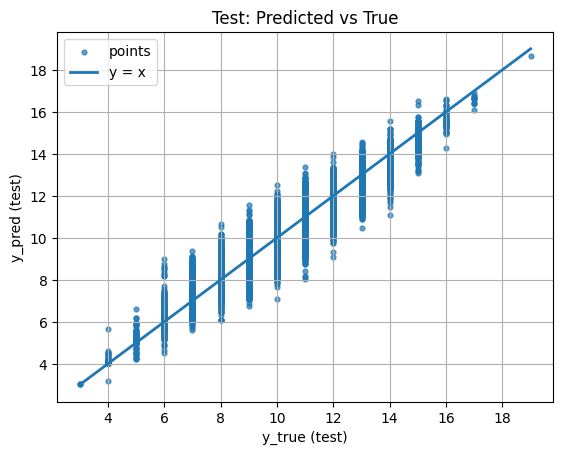

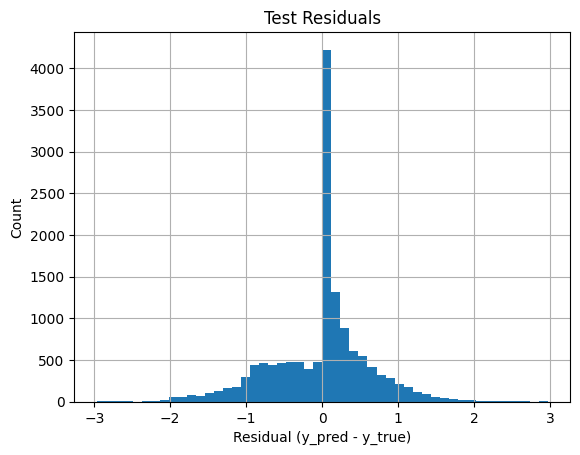

In [8]:
import matplotlib.pyplot as plt

# =========================
# test eval + predictions
# =========================
net.eval()
with torch.no_grad():
    yhat_test = net(x_test)
    test_mse = criterion(yhat_test, y_test).item()
    r2 = 1.0 - ((yhat_test - y_test).pow(2).sum() /
                ((y_test - y_test.mean()).pow(2).sum() + 1e-12)).item()
print("test MSE:", test_mse)
print("test R^2 :", r2)

# =========================
# PLOTS
# =========================

# 1) loss curves - commented out as train_losses and val_losses are not defined
# plt.figure()
# plt.plot(range(1, epochs + 1), train_losses, label="train MSE")
# plt.plot(range(1, epochs + 1), val_losses,   label="val MSE")
# plt.xlabel("Epoch")
# plt.ylabel("Loss (MSE)")
# plt.title("Training / Validation Loss")
# plt.legend()
# plt.grid(True)
# plt.show()

# 2) scatter: y_true vs y_pred (test)
yt = y_test.numpy().flatten()
yp = yhat_test.numpy().flatten()
mn = min(yt.min(), yp.min())
mx = max(yt.max(), yp.max())

plt.figure()
plt.scatter(yt, yp, s=12, alpha=0.7, label="points")
plt.plot([mn, mx], [mn, mx], linewidth=2, label="y = x")
plt.xlabel("y_true (test)")
plt.ylabel("y_pred (test)")
plt.title("Test: Predicted vs True")
plt.legend()
plt.grid(True)
plt.show()

# 3) histogram of residuals (test)
res = (yp - yt)
plt.figure()
plt.hist(res, bins=50)
plt.xlabel("Residual (y_pred - y_true)")
plt.ylabel("Count")
plt.title("Test Residuals")
plt.grid(True)
plt.show()